## 此版本现在多了confusion matrix, 取消l2, 进行finetune

In [1]:
from torchvision import transforms, utils
from torchvision import datasets
import torch
import matplotlib.pyplot as plt 
from torch.utils import data
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data.sampler import SubsetRandomSampler
import copy
from sklearn.metrics import confusion_matrix

## load data

In [2]:
# def splitData(datadir,val_size = 0.2):
    
#     train_trainsforms = transforms.Compose([transforms.RandomResizedCrop(299),
#                 transforms.RandomHorizontalFlip(),
#                 transforms.RandomRotation(30),
#                 transforms.ToTensor(),
#                 #transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
#                 transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
#     val_trainsforms = transforms.Compose([transforms.RandomResizedCrop(299),
#                 transforms.ToTensor(),
#                 transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
# ])

#     train_data = datasets.ImageFolder(datadir,transform=train_trainsforms)
#     val_data = datasets.ImageFolder(datadir,transform=val_trainsforms)

#     num = len(train_data)                              
#     idx = list(range(num))                         
#     split = int(np.floor(val_size * num))         
#     np.random.shuffle(idx)                              

#     val_idx, train_idx = idx[:split], idx[split:]
#     train_sampler = SubsetRandomSampler(train_idx)            
#     val_sampler  = SubsetRandomSampler(val_idx)
#     train_loader = data.DataLoader(train_data,sampler=train_sampler,batch_size=64)
#     val_loader = data.DataLoader(val_data,sampler=val_sampler,batch_size=64)
    
#     return train_loader,val_loader


In [3]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = 1/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]  
    print(N)
    print(weight_per_class)
    return weight

In [4]:
#train_data_dir = 'OCT2017/test/'
#train_loader, val_loader = splitData(train_data_dir,val_size = 0.2)
batch_size = 128
train_size = 1600
train_data = datasets.ImageFolder(root='OCT2017/train_limit/', transform=transforms.Compose([
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

val_data = datasets.ImageFolder(root='OCT2017/val/', transform=transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

test_data = datasets.ImageFolder(root='OCT2017/test/', transform=transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

weights = make_weights_for_balanced_classes(train_data.imgs, len(train_data.classes))
weights = torch.DoubleTensor(weights)
#weight_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
weight_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, train_size)

train_loader = data.DataLoader(train_data,
                               batch_size=batch_size,
                               sampler = weight_sampler
                                            )
       

val_loader = data.DataLoader(val_data,
                             batch_size=batch_size,
                             shuffle=True,
                                        )


test_loader = data.DataLoader(test_data,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            )
       


1600.0
[0.0025, 0.0025, 0.0025, 0.0025]


/home/ruochenwen/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


In [5]:
print(len(val_loader))
82484.0
[2.232011906372615, 7.4323301495765, 9.859431030360986, 3.164550163053904]


8


[2.232011906372615, 7.4323301495765, 9.859431030360986, 3.164550163053904]

## load pre-trained model

In [6]:
import torchvision.models as models
resnet = models.resnet50(pretrained=True)


In [7]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## parameter setting

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
#     else:
#         for parma in model.parameters():
#             parma.requires_grad = False
#         for parma in model.layer4.parameters():
#              parma.requires_grad=True
#         for parma in model.layer3.parameters():
#              parma.requires_grad=True
#         for parma in model.layer2.parameters():
#              parma.requires_grad=True
#         for parma in model.layer1.parameters():
#              parma.requires_grad=True
    else:
        for param in model.parameters():
            param.requires_grad = True
        


In [9]:
feature_extract = True
para = set_parameter_requires_grad(resnet, feature_extract)

num_ftrs = resnet.fc.in_features
#inception.fc=nn.Linear(num_ftrs, out_features=4, bias=True)
#fc1 = nn.Linear(num_ftrs, out_features=1000, bias=True)
#resnet.fc = nn.Linear(num_ftrs, out_features=4, bias=True)
resnet.fc =nn.Sequential(nn.Linear(num_ftrs, out_features=1000, bias=True),
                              nn.Linear(1000, out_features=4, bias=True)
                                 )


## optimizer setting

In [10]:
params_to_update = resnet.parameters()

fc_params = list(map(id, resnet.fc.parameters()))
base_params = filter(lambda p: id(p) not in fc_params,
                     resnet.parameters())


print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in resnet.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
else:
    conv_para = []
    fc_para = []
    print("fine tune:")
    for name,param in resnet.named_parameters():
        if param.requires_grad == True:
            print("\t", name)


        
# Observe that all parameters are being optimized
#optimizer_inception = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

optimizer_resnet = optim.Adam(list(filter(lambda p: p.requires_grad,resnet.parameters())), lr=5e-4, betas=(0.9, 0.99))
#optimizer_inception = optim.Adam(params_to_update, lr=0.001, betas=(0.9, 0.99))
#optimizer_resnet = optim.Adam([{'params': resnet.fc.parameters(), 'lr': 5e-5},
#                      {'params': base_params, 'lr': 5e-5}], betas=(0.9, 0.99))

Params to learn:


In [11]:
# def exp_lr_scheduler(optimizer, epoch, lr_decay_epoch=5):
#     """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = param_group['lr'] * (0.1**(epoch // lr_decay_epoch))
#         # param_group['lr'] = param_group['lr']
#     if epoch % lr_decay_epoch == 0:
#         for param_group in optimizer.param_groups:
#             print('LR is set to {}'.format(param_group['lr']))
            
#     return optimizer


In [12]:
def exp_lr_scheduler(optimizer, epoch, init_lr=5e-5, lr_decay_epoch=10):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.3**(epoch // lr_decay_epoch))
    if epoch % lr_decay_epoch == 0:
        
        print('LR is set to {}'.format(lr))
 
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
 
    return optimizer

## train model

In [13]:
use_cuda = 1
if use_cuda:
    resnet = resnet.cuda()

In [14]:
def train(model, trainloaders, valloaders, criterion, optimizer, lr_scheduler, num_epoch):
    since =time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss, val_loss = [], []
    
    for epoch in range(num_epoch):
        
        model.train()
        optimizer = lr_scheduler(optimizer, epoch)
        steps = 0
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print('-'*10)
                
        running_loss = 0.0
        running_corrects = 0 
        for inputs, labels in trainloaders:
            #print("train labels number:",len(labels.data))
            #model.train()
            steps += 1
            #print("train labels:",labels.data)
            inputs = inputs.cuda()
            labels = labels.cuda()
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss_outputs = criterion(outputs, labels)
            loss = loss_outputs
            _,preds = torch.max(outputs,1)
            
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item() 
            running_corrects += torch.sum(preds == labels.data)
        
        val_running_loss = 0.0
        val_running_corrects = 0
        model.eval()
        step = 0
        with torch.no_grad():
            for inputs, labels in valloaders:
                step += 1
                inputs = inputs.cuda()
                labels = labels.cuda()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _,preds = torch.max(outputs,1)
                val_running_corrects += torch.sum(preds == labels.data)

        train_loss.append(running_loss / len(trainloaders))
        val_loss.append(val_running_loss / len(valloaders))
        
        train_acc = running_corrects.double() / len(trainloaders.dataset)
        val_acc = val_running_corrects.double() / len(valloaders.dataset)
        
        print(f"Train loss: {running_loss / len(trainloaders):.3f}.."
              f"Train accuracy:{train_acc:.3f}.."
              f"Val loss: {val_running_loss/len(valloaders):.3f}.."
              f"Val accuracy: {val_acc:.3f}.."
             )

                
        # deep copy the model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            val_acc_history.append(val_acc)



    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    conf_matrix = confusion_matrix(preds.data.cpu().numpy(), labels.data.cpu().numpy())
    print(conf_matrix)
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, val_acc_history, train_loss, val_loss, conf_matrix
    

LR is set to 5e-05
Epoch 1/20
----------
Train loss: 1.314..Train accuracy:0.421..Val loss: 1.286..Val accuracy: 0.483..
Epoch 2/20
----------
Train loss: 1.160..Train accuracy:0.597..Val loss: 1.201..Val accuracy: 0.524..
Epoch 3/20
----------
Train loss: 1.058..Train accuracy:0.616..Val loss: 1.110..Val accuracy: 0.561..
Epoch 4/20
----------
Train loss: 0.968..Train accuracy:0.662..Val loss: 0.972..Val accuracy: 0.671..
Epoch 5/20
----------
Train loss: 0.929..Train accuracy:0.672..Val loss: 0.933..Val accuracy: 0.664..
Epoch 6/20
----------
Train loss: 0.885..Train accuracy:0.662..Val loss: 0.886..Val accuracy: 0.682..
Epoch 7/20
----------
Train loss: 0.870..Train accuracy:0.684..Val loss: 0.860..Val accuracy: 0.689..
Epoch 8/20
----------
Train loss: 0.840..Train accuracy:0.683..Val loss: 0.853..Val accuracy: 0.681..
Epoch 9/20
----------
Train loss: 0.810..Train accuracy:0.700..Val loss: 0.824..Val accuracy: 0.701..
Epoch 10/20
----------
Train loss: 0.757..Train accuracy:0.723.

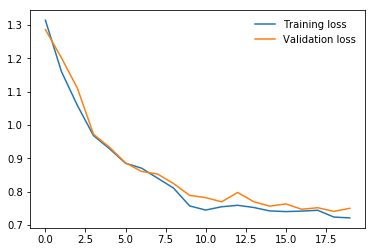

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optimizer_resnet
_, hist,train_loss,val_loss,cm = train(resnet, train_loader, val_loader, criterion, optimizer, exp_lr_scheduler, num_epoch =20)

plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(frameon=False)
plt.savefig("model_3.png")
plt.show()





In [16]:
print(cm)

[[16  4  4  0]
 [ 2 13  3  2]
 [ 4  3 24  3]
 [ 0  2  3 21]]


In [17]:
def inference(model, testloaders, criterion):
    test_running_corrects = 0
    test_running_loss = 0
    with torch.no_grad():
        for inputs, labels in testloaders:
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _,preds = torch.max(outputs,1)
            
            test_running_corrects += torch.sum(preds == labels.data)

    test_acc = test_running_corrects.double() / len(testloaders.dataset)
    conf_matrix = confusion_matrix(preds.data.cpu().numpy(), labels.data.cpu().numpy())
    print(conf_matrix)
    print(f"Loss of the network on the 1000 test images: {test_running_loss/len(testloaders):.3f}.."
          f"Accuracy of the network on the 1000 test images: {test_acc:.3f}.."
         )

In [18]:
inference(resnet, test_loader, criterion)

[[21  5  3  0]
 [ 2 14  0  2]
 [ 2  2 24  1]
 [ 0  1  0 27]]
Loss of the network on the 1000 test images: 0.580..Accuracy of the network on the 1000 test images: 0.842..
